In [1]:
'''import os
import tensorflow as tf
#You can set the fraction of GPU memory to be allocated when you construct a tf.Session by
#passing a tf.GPUOptions as part of the optional config argument:
# Assume that you have 12GB of GPU memory and want to allocate ~4GB:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
####################################################################################################################
#If memory growth is enabled for a PhysicalDevice, the runtime initialization will not allocate all memory on the device. Memory growth can\not be configured on a PhysicalDevice with virtual devices configured.
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass
####################################################################################################################
#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print("Num GPUs Availaable: ", len(tf.config.list_physical_devices('GPU')))'''

'import os\nimport tensorflow as tf\n#You can set the fraction of GPU memory to be allocated when you construct a tf.Session by\n#passing a tf.GPUOptions as part of the optional config argument:\n# Assume that you have 12GB of GPU memory and want to allocate ~4GB:\ngpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)\nsess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))\n####################################################################################################################\n#If memory growth is enabled for a PhysicalDevice, the runtime initialization will not allocate all memory on the device. Memory growth can\not be configured on a PhysicalDevice with virtual devices configured.\nphysical_devices = tf.config.list_physical_devices(\'GPU\')\ntry:\n  tf.config.experimental.set_memory_growth(physical_devices[0], True)\nexcept:\n  # Invalid device or cannot modify virtual devices once initialized.\n  pass\n###########################################

In [2]:
#time and memory profiling needed
import os
import gc
import sys
import psutil
import numpy as np
import pandas as pd
import tensorflow as tf
import _pickle as pickle
from itertools import repeat
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.compat.v1 import ConfigProto, InteractiveSession

In [3]:
#from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'        #verbose INFO, WARNING, and ERROR messages are not printed
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.75       #3G vram
session = InteractiveSession(config=config)
session.close()                                 #to release resourses held by other interactive sessions
physical_devices = tf.config.list_physical_devices('GPU')

#If memory growth is enabled for a PhysicalDevice, the runtime initialization will not allocate all memory on the device. Memory growth can\not be configured on a PhysicalDevice with virtual devices configured.
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [4]:
open_file = open("RML2016.10b.dat",'rb')
data = pickle.load(open_file, encoding='latin1')
x=np.array(list(data.values()),dtype=np.float32)        #values     #(200, 6000, 2, 128)
y=np.array(list(data.keys()))                           #keys tubles (mod,snr)       #(200, 2)
del open_file

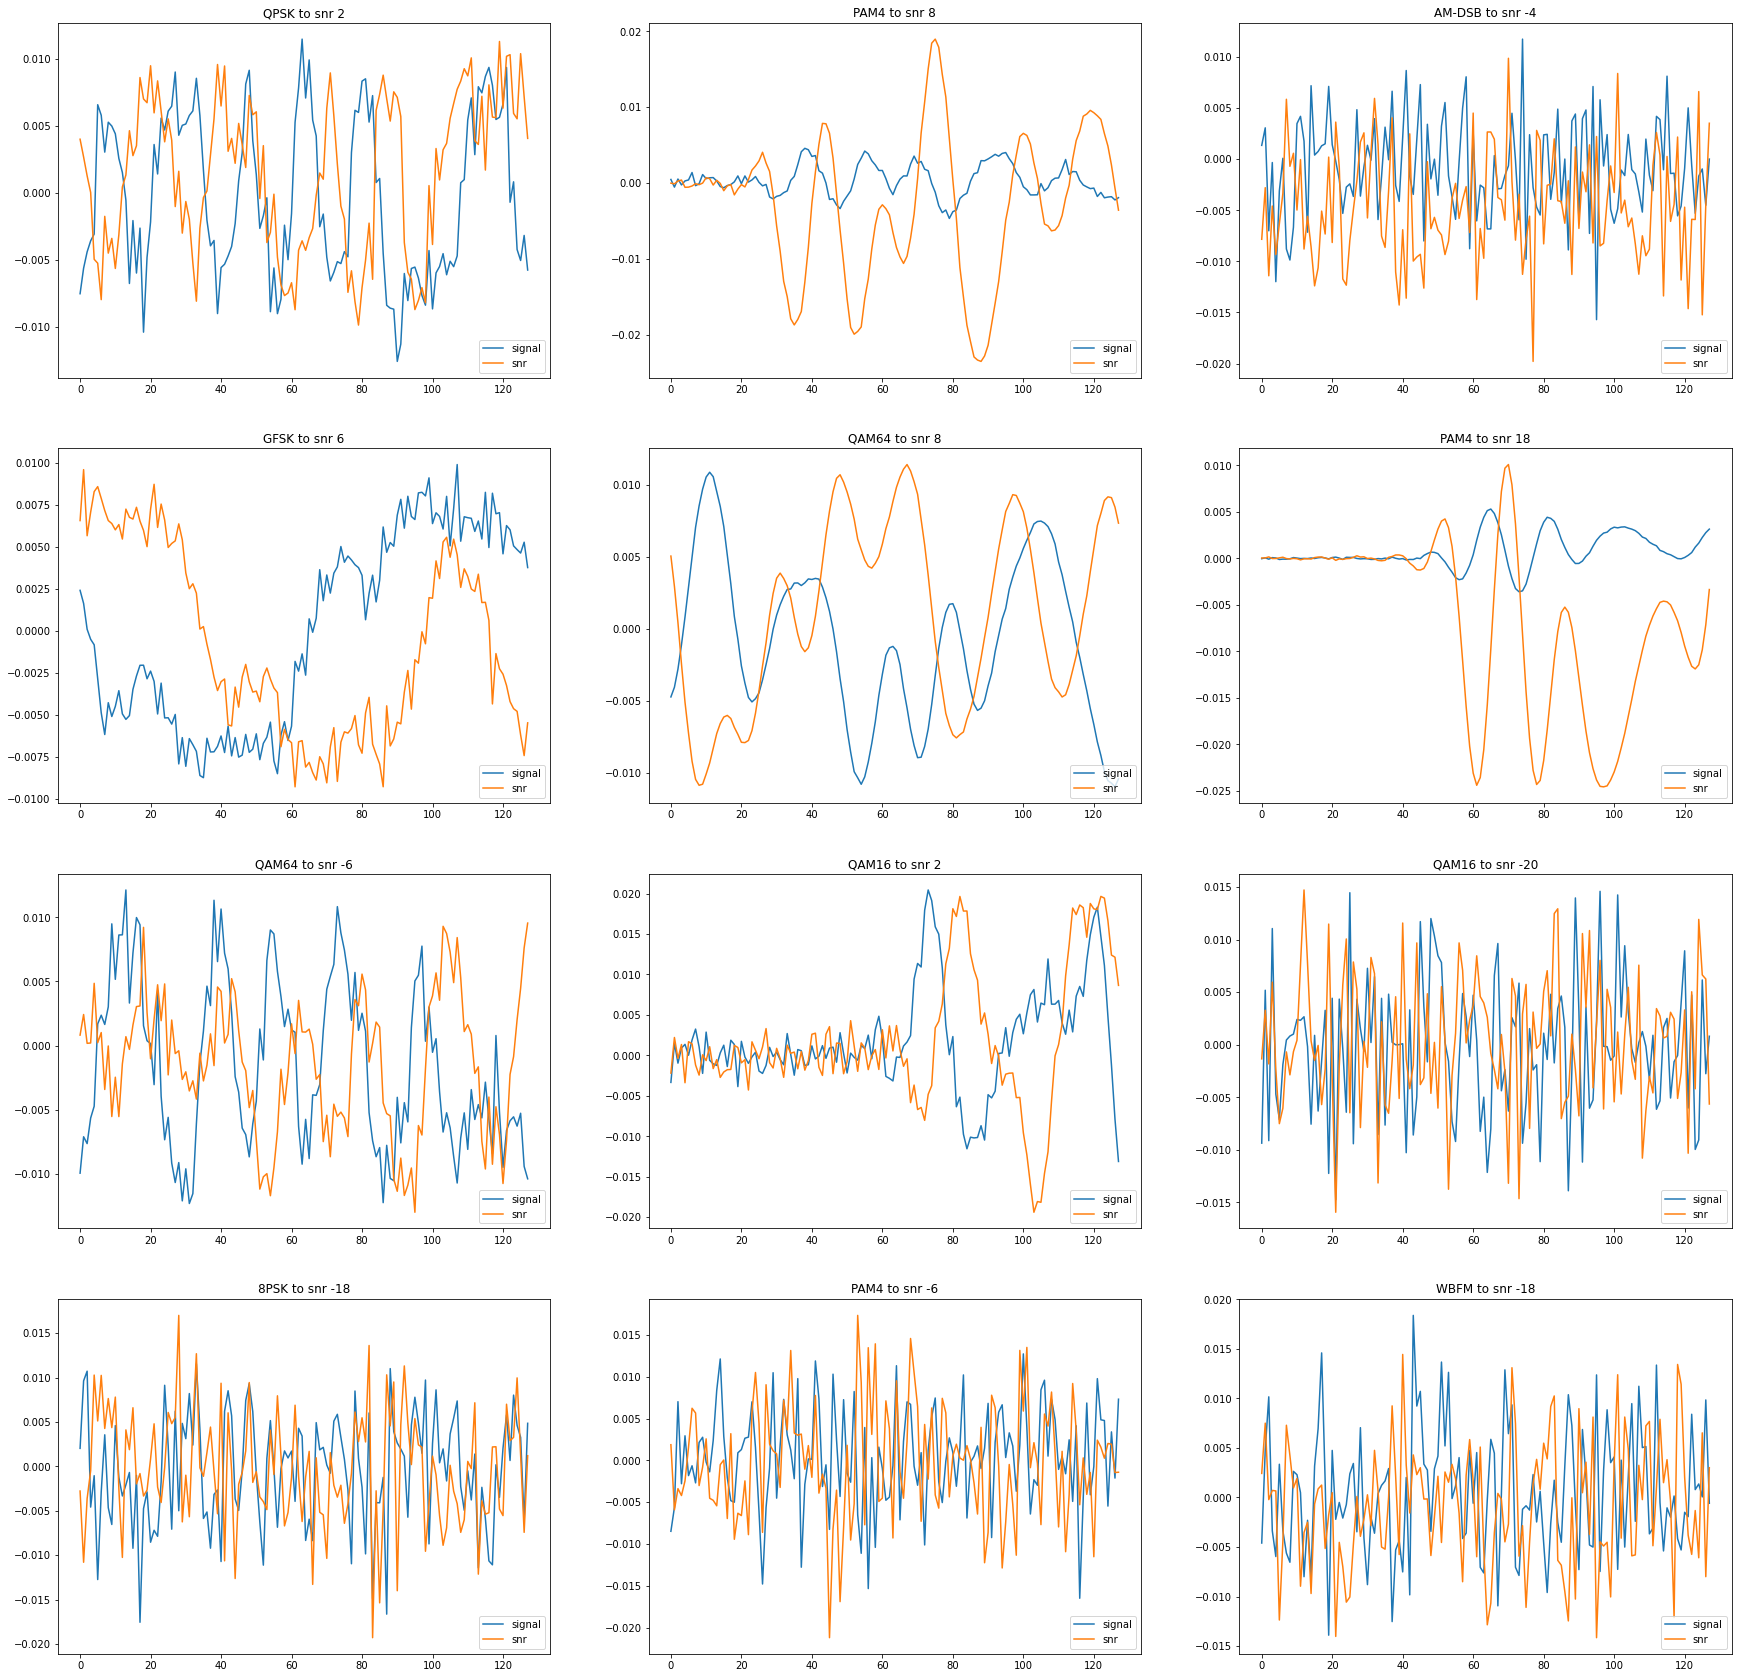

In [5]:
#plot samples for modulations
fig, axs = plt.subplots(4, 3,figsize=(30,30))
for i in range(4):
    for j in range(3):
        axs[i,j].plot(  x[(i*3)+j][0][0]  )   #signal
        axs[i,j].plot(  x[(i*3)+j][0][1]  )   #snr
        axs[i,j].set_title(y[(i*3)+j][0]+" to snr "+y[(i*3)+j][1])
        axs[i,j].legend(["signal", "snr"], loc ="lower right")

In [6]:
x=x.reshape((x.shape[0]*x.shape[1],x.shape[2],x.shape[3]))  #FLATTEN ALL SAMPLES

In [7]:
le = preprocessing.LabelEncoder()   #encoder
snr=y[:,1:]              #separate snr
snr=np.ravel(snr)       ##
snr_classes=np.unique(snr)
y=np.delete(y, 1, 1)   ##drop snr
classes=np.unique(y)
y=np.ravel(y)       ##
y=le.fit_transform(y)   ##encode mods

list=[]     #expand lables(mods) for all features
snrlist=[]  #expand snr for all features
for i in range (y.shape[0]):
    list.extend(repeat(y[i],6000))
    snrlist.extend(repeat(snr[i],6000))

y=np.array(list,dtype=np.int8)                  #help in fitting vram by reducing space
snr=np.array(snrlist,dtype=np.float16)          #help in fitting vram by reducing space

del list,snrlist

In [8]:
def evaluate(x):
    results = model.predict(x)
    return results

In [9]:
def  add_der(x):            #add derivative
    features=np.zeros((x.shape[0],x.shape[1]+2,128),dtype=np.float32)
    #print("features :",features.shape)
    for i in range(x.shape[0]):
        diff=np.diff(x[i][0:2,:])
        c=np.empty((2,1))
        c[0][0]=diff[0][126]
        c[1][0]=diff[1][126]
        diff=np.append(diff,c,axis= 1)
        features[i]=np.concatenate((x[i],diff), axis=0)
    x=None
    x=features
    features=None
    return x

In [10]:
def  add_integral(x):           #add integration
    from scipy import integrate
    features=np.zeros((x.shape[0],x.shape[1]+2,128),dtype=np.float32)
    #print("features :",features.shape)
    for i in range(x.shape[0]):
        integral=integrate.cumtrapz(x[i][0:2], initial=0)
        features[i]=np.concatenate((x[i],integral), axis=0)
    x=None
    x=features
    features=None
    return x

In [11]:
#check for ram and vram used for project (vram is idle as tensors not activated yet)
print("BEFORE VRAM Used By GPU:0 :",  tf.config.experimental.get_memory_usage('GPU:0'))
gc.collect()
print("Num GPUs Availaable: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Availaable: ", tf.config.list_physical_devices('GPU'))
print("VRAM Used By GPU:0 :",  tf.config.experimental.get_memory_usage('GPU:0'))
print("RAM Used  :",  psutil.Process().memory_info().rss / (1024 * 1024))

Instructions for updating:
Use tf.config.experimental.get_memory_info(device)['current'] instead.
BEFORE VRAM Used By GPU:0 : 0
Num GPUs Availaable:  1
GPUs Availaable:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
VRAM Used By GPU:0 : 0
RAM Used  : 3257.95703125


In [12]:
def rnn_model():        #rnn model
    model=keras.Sequential()
    model.add(keras.Input(shape=(None,128)))
    model.add(layers.SimpleRNN(512,return_sequences=True,activation='tanh'))
    model.add(layers.SimpleRNN(512,activation='tanh'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    print(model.summary())
    return model

In [13]:
def rnn_train(epochs,batch,new=True,model=None,features="R"):       # RAW--> R DIFF-->D INTEG-->I
    file='saved_'+features+'_rnn.hdf5'                              #to save model
    if not new:
        model=load_model(file)
    weight_save_callback = ModelCheckpoint(file, monitor='val_accuracy', verbose=0,save_best_only=False, mode='auto',save_freq='epoch')
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate=0.001 ), metrics=["accuracy"])
    model.fit(x_train,y_train,batch_size=batch,epochs=epochs,verbose=2,callbacks=[weight_save_callback])
    tf.keras.backend.clear_session()

In [12]:
# note --> that sequence of features for just rnn       #add features
x=add_integral(x)
x=add_der(x)
#model=rnn_model()    #call rnn model

features : (1200000, 4, 128)
features : (1200000, 6, 128)


In [23]:
##  RNN MODEL FOR (RAW+INTEGRATION) 4 FEATURES
x_train_val, x_test, y_train_val, y_test , snr_train_val,snr_test= train_test_split(x[:,:4,:], y, snr,random_state=0, train_size = 0.7)
x_train, x_val, y_train, y_val  ,snr_train,snr_val= train_test_split(x_train_val, y_train_val,snr_train_val, random_state=0, train_size = 0.95)
model=rnn_model()
rnn_train(10,batch=64,features="RI",model=model)
gc.collect()
del x_train_val, x_test, y_train_val, y_test,x_train, x_val, y_train, y_val
#3848

float32
int8


In [16]:
##  RNN MODEL FOR (RAW) 2 FEATURES
x_train_val, x_test, y_train_val, y_test = train_test_split(x[:,:2,:], y, random_state=0, train_size = 0.7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, train_size = 0.95)
rnn_train(epochs=10,batch=1024,features="R",model=model)
gc.collect()
del x_train_val, x_test, y_train_val, y_test,x_train, x_val, y_train, y_val

Epoch 1/10
780/780 - 24s - loss: 1.9440 - accuracy: 0.2397 - 24s/epoch - 31ms/step
Epoch 2/10
780/780 - 20s - loss: 1.7678 - accuracy: 0.2936 - 20s/epoch - 25ms/step
Epoch 3/10
780/780 - 22s - loss: 1.6908 - accuracy: 0.3122 - 22s/epoch - 28ms/step
Epoch 4/10
780/780 - 20s - loss: 1.6022 - accuracy: 0.3406 - 20s/epoch - 25ms/step
Epoch 5/10
780/780 - 20s - loss: 1.4876 - accuracy: 0.3864 - 20s/epoch - 25ms/step
Epoch 6/10
780/780 - 19s - loss: 1.4090 - accuracy: 0.4182 - 19s/epoch - 25ms/step
Epoch 7/10
780/780 - 20s - loss: 1.3582 - accuracy: 0.4395 - 20s/epoch - 25ms/step
Epoch 8/10
780/780 - 19s - loss: 1.3231 - accuracy: 0.4538 - 19s/epoch - 25ms/step
Epoch 9/10
780/780 - 20s - loss: 1.2972 - accuracy: 0.4647 - 20s/epoch - 25ms/step
Epoch 10/10
780/780 - 20s - loss: 1.2784 - accuracy: 0.4711 - 20s/epoch - 25ms/step


In [17]:
##  RNN MODEL FOR (INTEGRATION) 2 FEATURES
x_train_val, x_test, y_train_val, y_test = train_test_split(x[:,2:4,:], y, random_state=0, train_size = 0.7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, train_size = 0.95)
rnn_train(epochs=10,batch=1024,features="I",model=model)
gc.collect()
del x_train_val, x_test, y_train_val, y_test,x_train, x_val, y_train, y_val

Epoch 1/10
780/780 - 21s - loss: 2.3192 - accuracy: 0.2686 - 21s/epoch - 27ms/step
Epoch 2/10
780/780 - 20s - loss: 1.5397 - accuracy: 0.3565 - 20s/epoch - 25ms/step
Epoch 3/10
780/780 - 22s - loss: 1.4236 - accuracy: 0.4081 - 22s/epoch - 28ms/step
Epoch 4/10
780/780 - 21s - loss: 1.3599 - accuracy: 0.4344 - 21s/epoch - 27ms/step
Epoch 5/10
780/780 - 21s - loss: 1.3241 - accuracy: 0.4490 - 21s/epoch - 27ms/step
Epoch 6/10
780/780 - 21s - loss: 1.2978 - accuracy: 0.4599 - 21s/epoch - 27ms/step
Epoch 7/10
780/780 - 20s - loss: 1.2806 - accuracy: 0.4669 - 20s/epoch - 25ms/step
Epoch 8/10
780/780 - 20s - loss: 1.2653 - accuracy: 0.4737 - 20s/epoch - 25ms/step
Epoch 9/10
780/780 - 20s - loss: 1.2507 - accuracy: 0.4790 - 20s/epoch - 26ms/step
Epoch 10/10
780/780 - 20s - loss: 1.2398 - accuracy: 0.4829 - 20s/epoch - 26ms/step


In [18]:
##  RNN MODEL FOR (DERIVATIVE) 2 FEATURES
x_train_val, x_test, y_train_val, y_test = train_test_split(x[:,4:,:], y, random_state=0, train_size = 0.7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, train_size = 0.95)
rnn_train(epochs=10,batch=1024,features="D",model=model)
gc.collect()
del x_train_val, x_test, y_train_val, y_test,x_train, x_val, y_train, y_val

Epoch 1/10
780/780 - 21s - loss: 1.7668 - accuracy: 0.2956 - 21s/epoch - 27ms/step
Epoch 2/10
780/780 - 20s - loss: 1.5539 - accuracy: 0.3579 - 20s/epoch - 25ms/step
Epoch 3/10
780/780 - 20s - loss: 1.5083 - accuracy: 0.3737 - 20s/epoch - 25ms/step
Epoch 4/10
780/780 - 20s - loss: 1.4827 - accuracy: 0.3857 - 20s/epoch - 25ms/step
Epoch 5/10
780/780 - 20s - loss: 1.4621 - accuracy: 0.3968 - 20s/epoch - 25ms/step
Epoch 6/10
780/780 - 20s - loss: 1.4440 - accuracy: 0.4052 - 20s/epoch - 26ms/step
Epoch 7/10
780/780 - 25s - loss: 1.4301 - accuracy: 0.4121 - 25s/epoch - 32ms/step
Epoch 8/10
780/780 - 22s - loss: 1.4154 - accuracy: 0.4196 - 22s/epoch - 28ms/step
Epoch 9/10
780/780 - 21s - loss: 1.4032 - accuracy: 0.4250 - 21s/epoch - 27ms/step
Epoch 10/10
780/780 - 20s - loss: 1.3908 - accuracy: 0.4301 - 20s/epoch - 25ms/step


In [21]:
##  RNN MODEL FOR (DIFF+INTEGRATION) 4 FEATURES
x_train_val, x_test, y_train_val, y_test = train_test_split(x[:,2:,:], y, random_state=0, train_size = 0.7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, train_size = 0.95)
rnn_train(epochs=10,batch=64,features="ID",model=model)
gc.collect()
del x_train_val, x_test, y_train_val, y_test,x_train, x_val, y_train, y_val

Epoch 1/10
12469/12469 - 425s - loss: 1.8718 - accuracy: 0.2672 - 425s/epoch - 34ms/step
Epoch 2/10
12469/12469 - 415s - loss: 1.6988 - accuracy: 0.3082 - 415s/epoch - 33ms/step
Epoch 3/10
12469/12469 - 415s - loss: 1.6791 - accuracy: 0.3120 - 415s/epoch - 33ms/step
Epoch 4/10
12469/12469 - 416s - loss: 1.6723 - accuracy: 0.3134 - 416s/epoch - 33ms/step
Epoch 5/10
12469/12469 - 414s - loss: 1.6693 - accuracy: 0.3138 - 414s/epoch - 33ms/step
Epoch 6/10
12469/12469 - 414s - loss: 1.6656 - accuracy: 0.3147 - 414s/epoch - 33ms/step
Epoch 7/10
12469/12469 - 416s - loss: 1.6633 - accuracy: 0.3170 - 416s/epoch - 33ms/step
Epoch 8/10
12469/12469 - 415s - loss: 1.6643 - accuracy: 0.3161 - 415s/epoch - 33ms/step
Epoch 9/10
12469/12469 - 416s - loss: 1.6656 - accuracy: 0.3158 - 416s/epoch - 33ms/step
Epoch 10/10
12469/12469 - 415s - loss: 1.6660 - accuracy: 0.3157 - 415s/epoch - 33ms/step


In [16]:
##  RNN MODEL FOR (RAW+DIFF) 4 FEATURES
x=np.concatenate((x[:,:2,:],x[:,4:,:]) ,axis=1)
x_train_val, x_test, y_train_val, y_test = train_test_split( x, y, random_state=0, train_size = 0.7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, train_size = 0.95)
rnn_train(epochs=10,batch=64,features="RD",model=model)
gc.collect()
del x_train_val, x_test, y_train_val, y_test,x_train, x_val, y_train, y_val
x=add_integral(x)

Epoch 1/10
12469/12469 - 235s - loss: 1.8123 - accuracy: 0.2750 - 235s/epoch - 19ms/step
Epoch 2/10
12469/12469 - 233s - loss: 1.5704 - accuracy: 0.3453 - 233s/epoch - 19ms/step
Epoch 3/10
12469/12469 - 238s - loss: 1.4795 - accuracy: 0.3819 - 238s/epoch - 19ms/step
Epoch 4/10
12469/12469 - 232s - loss: 1.4203 - accuracy: 0.4062 - 232s/epoch - 19ms/step
Epoch 5/10
12469/12469 - 232s - loss: 1.3850 - accuracy: 0.4222 - 232s/epoch - 19ms/step
Epoch 6/10
12469/12469 - 231s - loss: 1.3594 - accuracy: 0.4333 - 231s/epoch - 19ms/step
Epoch 7/10
12469/12469 - 232s - loss: 1.3381 - accuracy: 0.4429 - 232s/epoch - 19ms/step
Epoch 8/10
12469/12469 - 232s - loss: 1.3218 - accuracy: 0.4507 - 232s/epoch - 19ms/step
Epoch 9/10
12469/12469 - 230s - loss: 1.3084 - accuracy: 0.4555 - 230s/epoch - 18ms/step
Epoch 10/10
12469/12469 - 231s - loss: 1.2967 - accuracy: 0.4612 - 231s/epoch - 19ms/step


In [ ]:
############################################################################################################

In [14]:
def lstm_model():   #LSTM MODEL
    model = keras.Sequential()
    model.add(keras.Input(shape=(None, 128)))
    model.add(layers.LSTM(512, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(512, activation='tanh'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    print(model.summary())
    return model

In [15]:
def lstm_train(epochs, batch, new=True, model=None, features="R"):
    file = 'saved_' + features + '_LSTM.hdf5'
    if not new:
        model = load_model(file)
    weight_save_callback = ModelCheckpoint(file, monitor='val_accuracy', verbose=0, save_best_only=False, mode='auto',
                                           save_freq='epoch')
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch, epochs=epochs, verbose=2, callbacks=[weight_save_callback])
    tf.keras.backend.clear_session()

In [17]:
##R-> RAW (2)       ##I-> INTEGRATION (2)       ##D->DIFF (2)
x_train_val, x_test, y_train_val, y_test, snr_train_val, snr_test = train_test_split(x[:, :4, :], y, snr,random_state=0, train_size=0.7)
x_train, x_val, y_train, y_val, snr_train, snr_val = train_test_split(x_train_val, y_train_val, snr_train_val,random_state=0, train_size=0.95)
model = lstm_model()
lstm_train(10, batch=64, features="RI", model=model)
gc.collect()
del x_train_val, x_test, y_train_val, y_test, x_train, x_val, y_train, y_val
#3848

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 512)         1312768   
                                                                 
 lstm_1 (LSTM)               (None, 512)               2099200   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 3,577,482
Trainable params: 3,577,482
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
12469/12469 - 179s - loss: 1.6

In [16]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x[:, :2, :], y, random_state=0, train_size=0.7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, train_size=0.95)
lstm_train(epochs=10, batch=1024, features="R", model=model)
gc.collect()
del x_train_val, x_test, y_train_val, y_test, x_train, x_val, y_train, y_val

Epoch 1/10
780/780 - 37s - loss: 1.0541 - accuracy: 0.5536 - 37s/epoch - 47ms/step
Epoch 2/10
780/780 - 33s - loss: 1.0449 - accuracy: 0.5577 - 33s/epoch - 43ms/step
Epoch 3/10
780/780 - 33s - loss: 1.0392 - accuracy: 0.5605 - 33s/epoch - 42ms/step
Epoch 4/10
780/780 - 32s - loss: 1.0338 - accuracy: 0.5626 - 32s/epoch - 42ms/step
Epoch 5/10
780/780 - 35s - loss: 1.0293 - accuracy: 0.5647 - 35s/epoch - 45ms/step
Epoch 6/10
780/780 - 33s - loss: 1.0247 - accuracy: 0.5668 - 33s/epoch - 43ms/step
Epoch 7/10
780/780 - 35s - loss: 1.0206 - accuracy: 0.5686 - 35s/epoch - 45ms/step
Epoch 8/10
780/780 - 33s - loss: 1.0163 - accuracy: 0.5703 - 33s/epoch - 42ms/step
Epoch 9/10
780/780 - 33s - loss: 1.0120 - accuracy: 0.5721 - 33s/epoch - 42ms/step
Epoch 10/10
780/780 - 33s - loss: 1.0082 - accuracy: 0.5741 - 33s/epoch - 42ms/step


In [18]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x[:, 2:4, :], y, random_state=0, train_size=0.7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, train_size=0.95)
lstm_train(epochs=10, batch=1024, features="I", model=model)
gc.collect()
del x_train_val, x_test, y_train_val, y_test, x_train, x_val, y_train, y_val

Epoch 1/10
780/780 - 41s - loss: 1.4968 - accuracy: 0.4481 - 41s/epoch - 52ms/step
Epoch 2/10
780/780 - 38s - loss: 1.1635 - accuracy: 0.5190 - 38s/epoch - 48ms/step
Epoch 3/10
780/780 - 35s - loss: 1.1036 - accuracy: 0.5419 - 35s/epoch - 45ms/step
Epoch 4/10
780/780 - 38s - loss: 1.0739 - accuracy: 0.5537 - 38s/epoch - 48ms/step
Epoch 5/10
780/780 - 35s - loss: 1.0534 - accuracy: 0.5615 - 35s/epoch - 45ms/step
Epoch 6/10
780/780 - 37s - loss: 1.0363 - accuracy: 0.5683 - 37s/epoch - 47ms/step
Epoch 7/10
780/780 - 32s - loss: 1.0207 - accuracy: 0.5746 - 32s/epoch - 41ms/step
Epoch 8/10
780/780 - 32s - loss: 1.0060 - accuracy: 0.5810 - 32s/epoch - 41ms/step
Epoch 9/10
780/780 - 31s - loss: 0.9926 - accuracy: 0.5869 - 31s/epoch - 40ms/step
Epoch 10/10
780/780 - 33s - loss: 0.9802 - accuracy: 0.5926 - 33s/epoch - 42ms/step


In [19]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x[:, 4:, :], y, random_state=0, train_size=0.7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, train_size=0.95)
lstm_train(epochs=10, batch=1024, features="D", model=model)
gc.collect()
del x_train_val, x_test, y_train_val, y_test, x_train, x_val, y_train, y_val

Epoch 1/10
780/780 - 34s - loss: 2.3032 - accuracy: 0.1002 - 34s/epoch - 44ms/step
Epoch 2/10
780/780 - 31s - loss: 2.3026 - accuracy: 0.0993 - 31s/epoch - 40ms/step
Epoch 3/10
780/780 - 31s - loss: 2.3026 - accuracy: 0.0998 - 31s/epoch - 40ms/step
Epoch 4/10
780/780 - 31s - loss: 2.3026 - accuracy: 0.1006 - 31s/epoch - 39ms/step
Epoch 5/10
780/780 - 32s - loss: 2.3026 - accuracy: 0.0995 - 32s/epoch - 42ms/step
Epoch 6/10
780/780 - 31s - loss: 2.3026 - accuracy: 0.1001 - 31s/epoch - 40ms/step
Epoch 7/10
780/780 - 31s - loss: 2.3026 - accuracy: 0.0997 - 31s/epoch - 39ms/step
Epoch 8/10
780/780 - 31s - loss: 2.3026 - accuracy: 0.1005 - 31s/epoch - 39ms/step
Epoch 9/10
780/780 - 31s - loss: 2.3026 - accuracy: 0.0998 - 31s/epoch - 39ms/step
Epoch 10/10
780/780 - 31s - loss: 2.3026 - accuracy: 0.0998 - 31s/epoch - 39ms/step


In [20]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x[:, 2:, :], y, random_state=0, train_size=0.7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, train_size=0.95)
lstm_train(epochs=10, batch=64, features="ID", model=model)
gc.collect()
del x_train_val, x_test, y_train_val, y_test, x_train, x_val, y_train, y_val

Epoch 1/10
12469/12469 - 188s - loss: 1.1714 - accuracy: 0.5148 - 188s/epoch - 15ms/step
Epoch 2/10
12469/12469 - 182s - loss: 1.0958 - accuracy: 0.5431 - 182s/epoch - 15ms/step
Epoch 3/10
12469/12469 - 182s - loss: 1.0715 - accuracy: 0.5525 - 182s/epoch - 15ms/step
Epoch 4/10
12469/12469 - 180s - loss: 1.0508 - accuracy: 0.5604 - 180s/epoch - 14ms/step
Epoch 5/10
12469/12469 - 181s - loss: 1.0315 - accuracy: 0.5694 - 181s/epoch - 14ms/step
Epoch 6/10
12469/12469 - 176s - loss: 1.0129 - accuracy: 0.5781 - 176s/epoch - 14ms/step
Epoch 7/10
12469/12469 - 182s - loss: 0.9937 - accuracy: 0.5879 - 182s/epoch - 15ms/step
Epoch 8/10
12469/12469 - 186s - loss: 0.9754 - accuracy: 0.5974 - 186s/epoch - 15ms/step
Epoch 9/10
12469/12469 - 182s - loss: 0.9567 - accuracy: 0.6069 - 182s/epoch - 15ms/step
Epoch 10/10
12469/12469 - 183s - loss: 0.9364 - accuracy: 0.6176 - 183s/epoch - 15ms/step


In [21]:
x = np.concatenate((x[:, :2, :], x[:, 4:, :]), axis=1)
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, random_state=0, train_size=0.7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, train_size=0.95)
lstm_train(epochs=10, batch=64, features="RD", model=model)
gc.collect()
del x_train_val, x_test, y_train_val, y_test, x_train, x_val, y_train, y_val
x = add_integral(x)

Epoch 1/10
12469/12469 - 183s - loss: 1.2628 - accuracy: 0.4684 - 183s/epoch - 15ms/step
Epoch 2/10
12469/12469 - 193s - loss: 1.1159 - accuracy: 0.5301 - 193s/epoch - 15ms/step
Epoch 3/10
12469/12469 - 178s - loss: 1.0782 - accuracy: 0.5455 - 178s/epoch - 14ms/step
Epoch 4/10
12469/12469 - 183s - loss: 1.0566 - accuracy: 0.5546 - 183s/epoch - 15ms/step
Epoch 5/10
12469/12469 - 180s - loss: 1.0393 - accuracy: 0.5622 - 180s/epoch - 14ms/step
Epoch 6/10
12469/12469 - 178s - loss: 1.0233 - accuracy: 0.5704 - 178s/epoch - 14ms/step
Epoch 7/10
12469/12469 - 183s - loss: 1.0082 - accuracy: 0.5778 - 183s/epoch - 15ms/step
Epoch 8/10
12469/12469 - 178s - loss: 0.9926 - accuracy: 0.5858 - 178s/epoch - 14ms/step
Epoch 9/10
12469/12469 - 182s - loss: 0.9757 - accuracy: 0.5958 - 182s/epoch - 15ms/step
Epoch 10/10
12469/12469 - 178s - loss: 0.9590 - accuracy: 0.6044 - 178s/epoch - 14ms/step
features : (1200000, 6, 128)


In [21]:
##############################################################################################

In [16]:
def cnn_model(features_nu):     ##CNN MODEL
    model=keras.models.Sequential()
    model.add(layers.Reshape((128,features_nu,1), input_shape=(features_nu,128)))
    model.add(layers.Conv2D(  32  , (3,1) , padding='valid' , activation='relu',strides=1))
    model.add(layers.MaxPool2D(pool_size=(2, 1)))
    model.add(layers.Conv2D(  64  , (3,1) , padding='valid' , activation='relu',strides=1))
    model.add(layers.MaxPool2D(pool_size=(2, 1)))
    model.add(layers.Conv2D(  128  , (3,1) , padding='valid' , activation='relu',strides=1))
    model.add(layers.MaxPool2D(pool_size=(2, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    #model.summary()
    return model

In [17]:
# RAW--> R DIFF-->D INTEG-->I
def cnn_train(epochs,batch,new=True,model=None,features="R"):
    file='saved_'+features+'_cnn.hdf5'
    if not new:
        model=load_model(file)
    weight_save_callback = ModelCheckpoint(file, monitor='val_accuracy', verbose=0,save_best_only=False, mode='auto')
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=keras
        .optimizers.Adam(learning_rate=0.001 ), metrics=["accuracy"])
    model.fit(x_train,y_train,batch_size=batch,epochs=epochs,verbose=2,callbacks=[weight_save_callback])
    tf.keras.backend.clear_session()

In [16]:
x=add_der(x)
x=add_integral(x)

features : (1200000, 4, 128)
features : (1200000, 6, 128)


In [17]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x[:,0:2,:], y, random_state=0, train_size = 0.7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, train_size = 0.95)
model=cnn_model(2)
cnn_train(epochs=10,batch=1024,features="R",model=model)
gc.collect()
del x_train_val, x_test, y_train_val, y_test,x_train, x_val, y_train, y_val

Epoch 1/10
780/780 - 42s - loss: 1.6527 - accuracy: 0.3403 - 42s/epoch - 53ms/step
Epoch 2/10
780/780 - 37s - loss: 1.3258 - accuracy: 0.4617 - 37s/epoch - 48ms/step
Epoch 3/10
780/780 - 38s - loss: 1.2688 - accuracy: 0.4803 - 38s/epoch - 49ms/step
Epoch 4/10
780/780 - 35s - loss: 1.2309 - accuracy: 0.4924 - 35s/epoch - 45ms/step
Epoch 5/10
780/780 - 34s - loss: 1.1965 - accuracy: 0.5052 - 34s/epoch - 43ms/step
Epoch 6/10
780/780 - 34s - loss: 1.1675 - accuracy: 0.5161 - 34s/epoch - 43ms/step
Epoch 7/10
780/780 - 35s - loss: 1.1494 - accuracy: 0.5227 - 35s/epoch - 45ms/step
Epoch 8/10
780/780 - 34s - loss: 1.1351 - accuracy: 0.5280 - 34s/epoch - 43ms/step
Epoch 9/10
780/780 - 33s - loss: 1.1244 - accuracy: 0.5321 - 33s/epoch - 42ms/step
Epoch 10/10
780/780 - 33s - loss: 1.1171 - accuracy: 0.5353 - 33s/epoch - 43ms/step


In [18]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x[:,2:4,:], y, random_state=0, train_size = 0.7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, train_size = 0.95)
model=cnn_model(2)
cnn_train(epochs=10,batch=1024,features="D",model=model)
gc.collect()
del x_train_val, x_test, y_train_val, y_test,x_train, x_val, y_train, y_val

Epoch 1/10
780/780 - 33s - loss: 2.2925 - accuracy: 0.1194 - 33s/epoch - 43ms/step
Epoch 2/10
780/780 - 32s - loss: 2.2902 - accuracy: 0.1199 - 32s/epoch - 42ms/step
Epoch 3/10
780/780 - 32s - loss: 2.2900 - accuracy: 0.1197 - 32s/epoch - 42ms/step
Epoch 4/10
780/780 - 33s - loss: 2.2734 - accuracy: 0.1253 - 33s/epoch - 43ms/step
Epoch 5/10
780/780 - 33s - loss: 2.0840 - accuracy: 0.1813 - 33s/epoch - 43ms/step
Epoch 6/10
780/780 - 33s - loss: 1.8473 - accuracy: 0.2607 - 33s/epoch - 43ms/step
Epoch 7/10
780/780 - 35s - loss: 1.7910 - accuracy: 0.2741 - 35s/epoch - 45ms/step
Epoch 8/10
780/780 - 33s - loss: 1.7641 - accuracy: 0.2838 - 33s/epoch - 43ms/step
Epoch 9/10
780/780 - 33s - loss: 1.7441 - accuracy: 0.2942 - 33s/epoch - 42ms/step
Epoch 10/10
780/780 - 33s - loss: 1.7273 - accuracy: 0.3015 - 33s/epoch - 42ms/step


In [ ]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x[:,4:,:], y, random_state=0, train_size = 0.7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, train_size = 0.95)
model=cnn_model(2)
cnn_train(epochs=10,batch=1024,features="I",model=model)
gc.collect()
del x_train_val, x_test, y_train_val, y_test,x_train, x_val, y_train, y_val

Epoch 1/10
780/780 - 35s - loss: 1.5801 - accuracy: 0.3527 - 35s/epoch - 44ms/step
Epoch 2/10
780/780 - 34s - loss: 1.2682 - accuracy: 0.4754 - 34s/epoch - 43ms/step
Epoch 3/10
780/780 - 34s - loss: 1.1935 - accuracy: 0.5038 - 34s/epoch - 43ms/step
Epoch 4/10
780/780 - 34s - loss: 1.1499 - accuracy: 0.5207 - 34s/epoch - 43ms/step
Epoch 5/10
780/780 - 34s - loss: 1.1250 - accuracy: 0.5305 - 34s/epoch - 43ms/step
Epoch 6/10
780/780 - 36s - loss: 1.1054 - accuracy: 0.5379 - 36s/epoch - 46ms/step
Epoch 7/10
780/780 - 33s - loss: 1.0920 - accuracy: 0.5435 - 33s/epoch - 43ms/step
Epoch 8/10
780/780 - 33s - loss: 1.0816 - accuracy: 0.5472 - 33s/epoch - 43ms/step
Epoch 9/10
780/780 - 33s - loss: 1.0732 - accuracy: 0.5510 - 33s/epoch - 43ms/step
Epoch 10/10


In [ ]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x[:,:4,:], y, random_state=0, train_size = 0.7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, train_size = 0.95)
model=cnn_model(4)
cnn_train(epochs=10,batch=64,features="RD",model=model)
gc.collect()
del x_train_val, x_test, y_train_val, y_test,x_train, x_val, y_train, y_val

In [ ]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x[:,2:,:], y, random_state=0, train_size = 0.7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, train_size = 0.95)
model=cnn_model(4)
cnn_train(epochs=10,batch=64,features="ID",model=model)
gc.collect()
del x_train_val, x_test, y_train_val, y_test,x_train, x_val, y_train, y_val

In [17]:
x=np.concatenate((x[:,:2,:],x[:,4:,:]),axis=1)
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, random_state=0, train_size = 0.7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, train_size = 0.95)
model=cnn_model(4)
cnn_train(epochs=10,batch=64,features="RI",model=model)
gc.collect()
del x_train_val, x_test, y_train_val, y_test,x_train, x_val, y_train, y_val

Epoch 1/10
12469/12469 - 140s - loss: 1.3182 - accuracy: 0.4563 - 140s/epoch - 11ms/step
Epoch 2/10
12469/12469 - 134s - loss: 1.1429 - accuracy: 0.5243 - 134s/epoch - 11ms/step
Epoch 3/10
12469/12469 - 123s - loss: 1.1090 - accuracy: 0.5371 - 123s/epoch - 10ms/step
Epoch 4/10
12469/12469 - 123s - loss: 1.0921 - accuracy: 0.5438 - 123s/epoch - 10ms/step
Epoch 5/10
12469/12469 - 122s - loss: 1.0806 - accuracy: 0.5488 - 122s/epoch - 10ms/step
Epoch 6/10
12469/12469 - 125s - loss: 1.0715 - accuracy: 0.5522 - 125s/epoch - 10ms/step
Epoch 7/10
12469/12469 - 126s - loss: 1.0636 - accuracy: 0.5553 - 126s/epoch - 10ms/step
Epoch 8/10
12469/12469 - 123s - loss: 1.0566 - accuracy: 0.5578 - 123s/epoch - 10ms/step
Epoch 9/10
12469/12469 - 124s - loss: 1.0494 - accuracy: 0.5608 - 124s/epoch - 10ms/step
Epoch 10/10
12469/12469 - 122s - loss: 1.0427 - accuracy: 0.5630 - 122s/epoch - 10ms/step


352/352 [==============================] - 7s 19ms/step - loss: 1.1341 - accuracy: 0.5283


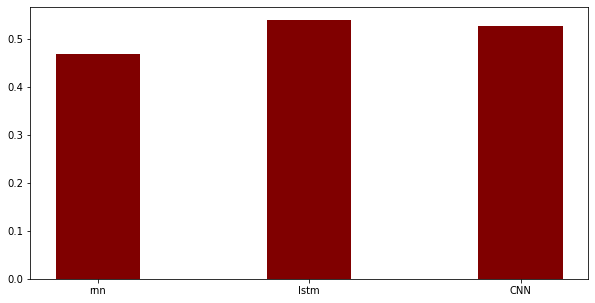

In [22]:
x=add_integral(x)
x=add_der(x)
x_train_val, x_test, y_train_val, y_test = train_test_split(x[:,:2,:], y,random_state=0, train_size = 0.7)

model=load_model("saved_R_rnn.hdf5")
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate=0.001 ), metrics=["accuracy"])
rnn= model.evaluate(x_test, y_test, batch_size=1024)

model=load_model("saved_R_LSTM.hdf5")
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate=0.001 ), metrics=["accuracy"])
lstm= model.evaluate(x_test, y_test, batch_size=1024)
#note that sequence of features for just rnn
del x_train_val, x_test, y_train_val, y_test

x1=np.array(list(data.values()),dtype=np.float32)
x1=x1.reshape((x1.shape[0]*x1.shape[1],x1.shape[2],x1.shape[3]))  #FLATTEN ALL SAMPLES
x1=add_der(x1)
x1=add_integral(x1)
x_train_val, x_test2, y_train_val, y_test2 = train_test_split(x[:,0:2,:], y, random_state=0, train_size = 0.7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, train_size = 0.95)
model=load_model("saved_R_cnn.hdf5")
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate=0.001 ), metrics=["accuracy"])
cnn= model.evaluate(x_test2, y_test2, batch_size=1024)
d = {'rnn':rnn[1], 'lstm':lstm[1] ,'CNN':cnn[1]}
courses = list(d.keys())
values = list(d.values())
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
gc.collect()
del x_train_val, x_test2, y_train_val, y_test2

352/352 [==============================] - 8s 22ms/step - loss: 1.0851 - accuracy: 0.5470


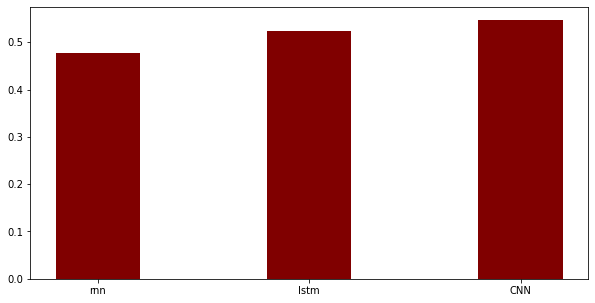

In [17]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x[:,2:4,:], y,random_state=0, train_size = 0.7)
model=load_model("saved_I_rnn.hdf5")
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate=0.001 ), metrics=["accuracy"])
rnn= model.evaluate(x_test, y_test, batch_size=1024)

model=load_model("saved_I_LSTM.hdf5")
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate=0.001 ), metrics=["accuracy"])
lstm= model.evaluate(x_test, y_test, batch_size=1024)

#note that sequence of features for just rnn
del x_train_val, x_test, y_train_val, y_test
x_train_val, x_test2, y_train_val, y_test2 = train_test_split(x1[:,4:,:], y, random_state=0, train_size = 0.7)
model=load_model("saved_I_cnn.hdf5")
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate=0.001 ), metrics=["accuracy"])
cnn= model.evaluate(x_test2, y_test2, batch_size=1024)
d = {'rnn':rnn[1], 'lstm':lstm[1] ,'CNN':cnn[1]}
courses = list(d.keys())
values = list(d.values())
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
gc.collect()
del x_train_val, x_test2, y_train_val, y_test2

352/352 [==============================] - 8s 22ms/step - loss: 1.7389 - accuracy: 0.2899


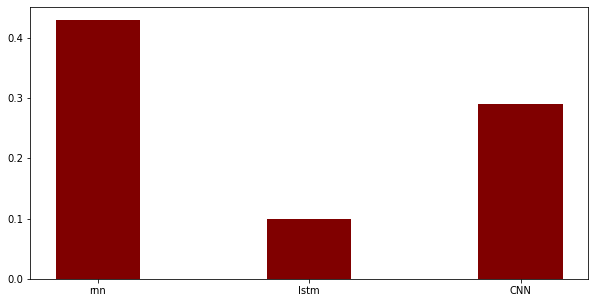

In [19]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x[:,4:,:], y,random_state=0, train_size = 0.7)
model=load_model("saved_D_rnn.hdf5")
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate=0.001 ), metrics=["accuracy"])
rnn= model.evaluate(x_test, y_test, batch_size=1024)

model=load_model("saved_D_LSTM.hdf5")
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate=0.001 ), metrics=["accuracy"])
lstm= model.evaluate(x_test, y_test, batch_size=1024)

#note that sequence of features for just rnn
del x_train_val, x_test, y_train_val, y_test
x_train_val, x_test2, y_train_val, y_test2 = train_test_split(x1[:,2:4,:], y, random_state=0, train_size = 0.7)
model=load_model("saved_D_cnn.hdf5")
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate=0.001 ), metrics=["accuracy"])
cnn= model.evaluate(x_test2, y_test2, batch_size=1024)
d = {'rnn':rnn[1], 'lstm':lstm[1] ,'CNN':cnn[1]}
courses = list(d.keys())
values = list(d.values())
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
gc.collect()
del x_train_val, x_test2, y_train_val, y_test2

In [21]:
x=np.array(list(data.values()),dtype=np.float32)
x=x.reshape((x.shape[0]*x.shape[1],x.shape[2],x.shape[3]))  #FLATTEN ALL SAMPLES
x=add_integral(x)
x=add_der(x)
x_train_val, x_test, y_train_val, y_test , snr_train_val,snr_test= train_test_split(x[:,2:,:], y, snr,random_state=0, train_size = 0.7)
x_train, x_val, y_train, y_val  ,snr_train,snr_val= train_test_split(x_train_val, y_train_val,snr_train_val, random_state=0, train_size = 0.95)
model=load_model("saved_ID_rnn.hdf5")
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate=0.001 ), metrics=["accuracy"])
rnn= model.evaluate(x_test, y_test, batch_size=1024)
model=load_model("saved_ID_LSTM.hdf5")
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate=0.001 ), metrics=["accuracy"])
lstm= model.evaluate(x_test, y_test, batch_size=1024)
#note that sequence of features for just rnn
x=np.array(list(data.values()),dtype=np.float32)
x=x.reshape((x.shape[0]*x.shape[1],x.shape[2],x.shape[3]))  #FLATTEN ALL SAMPLES
x=add_der(x)
x=add_integral(x)
x_train_val, x_test, y_train_val, y_test = train_test_split(x[:,2:,:], y, random_state=0, train_size = 0.7)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, random_state=0, train_size = 0.95)
model=load_model("saved_ID_cnn.hdf5")
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(learning_rate=0.001 ), metrics=["accuracy"])
cnn= model.evaluate(x_test, y_test, batch_size=1024)
d = {'rnn':rnn[1], 'lstm':lstm[1] ,'CNN':cnn[1]}
courses = list(d.keys())
values = list(d.values())
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
gc.collect()
del x

MemoryError: Unable to allocate 3.43 GiB for an array with shape (1200000, 6, 128) and data type float32